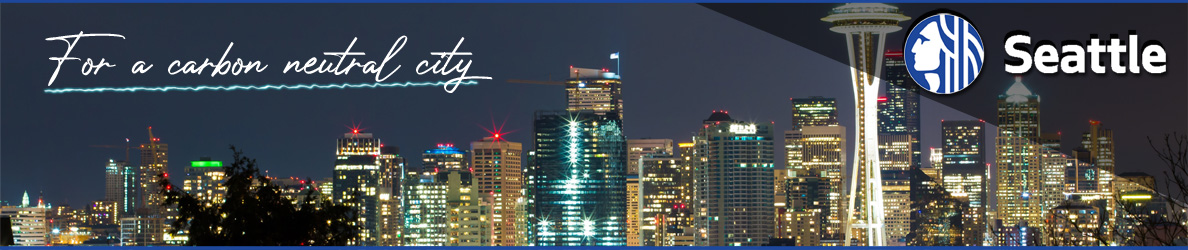

# <font color="#1d479b">Contexte</font>

Pour atteindre l'objectif de **ville neutre en émissions de carbone en 2050**, la ville de **Seattle** s’intéresse de près aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués en 2015 et en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, nous devons tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments pour lesquels elles n’ont pas encore été mesurées.

<hr width="50%" align="center"/>

Dans cette première partie, nous allons réaliser une **courte analyse exploratoire** après avoir nettoyé les données si besoin. Le but sera de déterminer les variables pertinentes ou d'en créer de nouvelles *(feature engineering)*.

# <font color="#1d479b">Sommaire</font>

1. [Chargement et adaptation des données de relèves](#section_1)     
    1.1. [Comparaison des colonnes des datasets](#section_1_1)     
    1.2. [Décompactage des données de localisation de 2015](#section_1_2)     
    1.3. [Description et nettoyage des données](#section_1_3)     
2. [Analyse exploratoire & Feature Engineering](#section_2)      
    2.1. [Les types de bâtiments](#section_2_1)     
    2.2. [Les années de construction](#section_2_2)     
    2.3. [Les corrélations linéaires](#section_2_3)     
    2.4. [Analyse des variables à prédire](#section_2_4)
3. [Dernières étapes de nettoyage](#section_3)
4. [Projection des établissements sur la carte de Seattle](#section_4)

## <font color="#337da4" id="section_1">1. Chargement et adaptation des données de relèves</font>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
sns.set_style("whitegrid")
sns.color_palette("crest", as_cmap=True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
data_2015 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/P3_prediction_energie_seattle/datas/2015-building-energy-benchmarking.csv")
data_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,Location,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,"{'latitude': '47.61219025', 'longitude': '-122...",7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,"{'latitude': '47.61310583', 'longitude': '-122...",7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,"{'latitude': '47.61334897', 'longitude': '-122...",7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,"{'latitude': '47.61421585', 'longitude': '-122...",7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,"{'latitude': '47.6137544', 'longitude': '-122....",7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576


In [4]:
data_2016 = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/P3_prediction_energie_seattle/datas/2016-building-energy-benchmarking.csv")
data_2016.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


Après avoir visualisé les premières lignes de ces 2 datasets, on remarque déjà que les colonnes ne sont pas identiques. Identifions les différences :

### <font color="#2cb7b0" id="section_1_1">1.1. Comparaison des colonnes des datasets</font>

In [5]:
def compare_colums(df1,df2):
    columns_1 = list(df1.columns) 
    columns_2 = list(df2.columns)
    same_columns=[]
    diff_columns_2=[]
    diff_columns_1=[]

    for col in columns_2:
        if col in columns_1:
            same_columns.append(col)
        else:
            diff_columns_2.append(col)
    for col in columns_1:
        if col not in columns_2:
            diff_columns_1.append(col)
    return diff_columns_1, diff_columns_2

In [6]:
diff_columns_2015, diff_columns_2016 = compare_colums(data_2015,data_2016)
diff_columns_2015

['Location',
 'OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes']

In [7]:
diff_columns_2016

['Address',
 'City',
 'State',
 'ZipCode',
 'Latitude',
 'Longitude',
 'Comments',
 'TotalGHGEmissions',
 'GHGEmissionsIntensity']

Les **données de localisation** ont évolué entre 2015 et 2016. On retrouve en plus l'adresse, la ville et la localisation GPS a été segmentée en `Latitude` et `Longitude`. Certaines autres variables comme `GHGEmissions(MetricTonsCO2e)` ont changé de nom *(il faudra vérifier si l'odre de grandeur des données à changer comparativement à* `TotalGHGEmissions` *de 2016)*.

### <font color="#2cb7b0" id="section_1_2">1.2. Décompactage des données de localisation de 2015</font>

In [8]:
data_2015['Location'][0]

'{\'latitude\': \'47.61219025\', \'longitude\': \'-122.33799744\', \'human_address\': \'{"address": "405 OLIVE WAY", "city": "SEATTLE", "state": "WA", "zip": "98101"}\'}'

On remarque que les données de localisation pour le jeu de données de 2015 sont "compactées" dans une sorte de double dictionnaire. Nous allons donc travailler cette variable pour extraire chacune des variables imbriquées :

In [9]:
import ast
data_2015['Location'] = [ast.literal_eval(str(item)) for index, item in data_2015.Location.iteritems()]
data_2015 = pd.concat([data_2015.drop(['Location'], axis=1), data_2015['Location'].apply(pd.Series)], axis=1)
data_2015['human_address'] = [ast.literal_eval(str(item)) for index, item in data_2015.human_address.iteritems()]
data_2015 = pd.concat([data_2015.drop(['human_address'], axis=1), data_2015['human_address'].apply(pd.Series)], axis=1)
data_2015.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),OtherFuelUse(kBtu),GHGEmissions(MetricTonsCO2e),GHGEmissionsIntensity(kgCO2e/ft2),DefaultData,Comment,ComplianceStatus,Outlier,2010 Census Tracts,Seattle Police Department Micro Community Policing Plan Areas,City Council Districts,SPD Beats,Zip Codes,latitude,longitude,address,city,state,zip
0,1,2015,NonResidential,Hotel,MAYFLOWER PARK HOTEL,659000030,7,DOWNTOWN,1927,1,12.0,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,65.0,78.9,80.3,173.5,175.1,6981428.0,7097539.0,2023032.0,1080307.0,3686160.0,12724.0,1272388.0,0.0,249.43,2.64,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.61219025,-122.33799744,405 OLIVE WAY,SEATTLE,WA,98101
1,2,2015,NonResidential,Hotel,PARAMOUNT HOTEL,659000220,7,DOWNTOWN,1996,1,11.0,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,51.0,94.4,99.0,191.3,195.2,8354235.0,8765788.0,0.0,1144563.0,3905411.0,44490.0,4448985.0,0.0,263.51,2.38,No,NaN,Compliant,NaN,NaN,14.0,NaN,31.0,18081,47.61310583,-122.33335756,724 PINE ST,SEATTLE,WA,98101
2,3,2015,NonResidential,Hotel,WESTIN HOTEL,659000475,7,DOWNTOWN,1969,1,41.0,961990,0,961990,"Hotel, Parking, Swimming Pool",Hotel,757243.0,Parking,100000.0,Swimming Pool,0.0,NaN,18.0,96.6,99.7,242.7,246.5,73130656.0,75506272.0,19660404.0,14583930.0,49762435.0,37099.0,3709900.0,0.0,2061.48,1.92,Yes,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,18081,47.61334897,-122.33769944,1900 5TH AVE,SEATTLE,WA,98101
3,5,2015,NonResidential,Hotel,HOTEL MAX,659000640,7,DOWNTOWN,1926,1,10.0,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,1.0,460.4,462.5,636.3,643.2,28229320.0,28363444.0,23458518.0,811521.0,2769023.0,20019.0,2001894.0,0.0,1936.34,31.38,No,NaN,Compliant,High Outlier,NaN,56.0,NaN,31.0,18081,47.61421585,-122.33660889,620 STEWART ST,SEATTLE,WA,98101
4,8,2015,NonResidential,Hotel,WARWICK SEATTLE HOTEL,659000970,7,DOWNTOWN,1980,1,18.0,119890,12460,107430,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,67.0,120.1,122.1,228.8,227.1,14829099.0,15078243.0,0.0,1777841.0,6066245.0,87631.0,8763105.0,0.0,507.70,4.02,No,NaN,Compliant,NaN,NaN,56.0,NaN,31.0,19576,47.6137544,-122.3409238,401 LENORA ST,SEATTLE,WA,98121


Nous avons à présent les colonnes correspondant à celles de 2016 : `latitude`, `longitude`, `address`, `city`, `state` et `zip`. Renommons les de la même façon :

In [10]:
data_2015 = data_2015.rename(columns={"latitude":"Latitude", "longitude":"Longitude",
                                      "address":"Address", "city":"City", 
                                      "state":"State", "zip":"ZipCode"})

Puis regardons à nouveau les différences de colonnes entre les 2 dataframes :

In [11]:
diff_columns_2015, diff_columns_2016 = compare_colums(data_2015,data_2016)
diff_columns_2015

['OtherFuelUse(kBtu)',
 'GHGEmissions(MetricTonsCO2e)',
 'GHGEmissionsIntensity(kgCO2e/ft2)',
 'Comment',
 '2010 Census Tracts',
 'Seattle Police Department Micro Community Policing Plan Areas',
 'City Council Districts',
 'SPD Beats',
 'Zip Codes']

In [12]:
diff_columns_2016

['Comments', 'TotalGHGEmissions', 'GHGEmissionsIntensity']

In [13]:
print(f"Description de la variable TotalGHGEmissions 2016 : \n\n",data_2016['TotalGHGEmissions'].describe(),
     f"\n\nDescription de la variable GHGEmissions(MetricTonsCO2e) 2015 : \n\n", data_2015['GHGEmissions(MetricTonsCO2e)'].describe())

Description de la variable TotalGHGEmissions 2016 : 

 count     3367.000000
mean       119.723971
std        538.832227
min         -0.800000
25%          9.495000
50%         33.920000
75%         93.940000
max      16870.980000
Name: TotalGHGEmissions, dtype: float64 

Description de la variable GHGEmissions(MetricTonsCO2e) 2015 : 

 count     3330.000000
mean       110.094102
std        409.450179
min          0.000000
25%          9.265000
50%         32.740000
75%         88.642500
max      11824.890000
Name: GHGEmissions(MetricTonsCO2e), dtype: float64


Les odres de grandeur des 2 variables sont identiques entre 2015 et 2016. Nous allons donc simplement renomer les colonnes à l'identique. Nous supprimons également les colonnes de 2015 n'ayant pas d'équivalent en 2016:

In [14]:
data_2015 = data_2015.rename(columns={'GHGEmissions(MetricTonsCO2e)':'TotalGHGEmissions',
                                     'GHGEmissionsIntensity(kgCO2e/ft2)':'GHGEmissionsIntensity',
                                     'Comment':'Comments'})
data_2015.drop(['OtherFuelUse(kBtu)','2010 Census Tracts',
                'Seattle Police Department Micro Community Policing Plan Areas',
                'City Council Districts','SPD Beats', 'Zip Codes'], axis=1, inplace=True)

In [15]:
diff_columns_2015, diff_columns_2016 = compare_colums(data_2015,data_2016)
print(diff_columns_2015,diff_columns_2016)

[] []


**Les variables des 2 datasets étant à présent identiques**, nous allons pouvoir les regrouper en un unique jeu de données :

In [16]:
data = pd.concat([data_2015[data_2016.columns],data_2016], axis = 0).sort_values(["DataYear", "OSEBuildingID"])
data.shape

(6716, 46)

### <font color="#2cb7b0" id="section_1_3">1.3. Description et nettoyage des données</font>

Il est précisié dans le projet que **seuls les bâtiments non destinés à l'habitation seront étudiés**. Nous allons donc supprimer toutes les lignes correspondant à des habitations en nous basant sur la variable `BuildingType`

In [17]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Multifamily LR (1-4)', 'Campus',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [18]:
data = data[~data['BuildingType'].str.contains("Multifamily")]
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'SPS-District K-12',
       'Campus', 'Nonresidential WA'], dtype=object)

In [19]:
print("Le jeu de données compte à présent {} lignes et {} colonnes.".format(data.shape[0],data.shape[1]))

Le jeu de données compte à présent 3318 lignes et 46 colonnes.


Nous allons également regarder s'il existe des **doublons sur l'identifiant** `OSEBuildingID`. On effet, nos modélisations devront porter sur un bâtiement unique *(ce n'est pas une modélisation temporelle)*. Nous prendrons donc en valeur la moyenne des variables sur les 2 années :

In [20]:
mean_columns = ['NumberofBuildings', 'NumberofFloors', 'PropertyGFATotal',
                'PropertyGFAParking', 'PropertyGFABuilding(s)',
                'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
                'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore', 'SiteEUI(kBtu/sf)',
                'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)',
                'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)', 'SteamUse(kBtu)',
                'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)',
                'NaturalGas(kBtu)', 'TotalGHGEmissions', 'GHGEmissionsIntensity']
OSEBuilding_means = data[['OSEBuildingID']+mean_columns].groupby('OSEBuildingID').mean()
OSEBuilding_means.head()

,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
OSEBuildingID,,,,,,,,,,,,,,,,,,,,,,
1,1.0,12.0,88434.0,0.0,88434.0,88434.0,NaN,NaN,62.5,80.299998,82.300002,178.000000,182.050000,7103895.25,7277224.50,2.013457e+06,1.118411e+06,3816093.5,12744.264650,1274420.5,249.705,2.735
2,1.0,11.0,103566.0,15064.0,88502.0,83880.0,15064.0,4622.0,56.0,94.600002,98.450001,183.700003,187.299997,8371084.00,8715133.50,0.000000e+00,1.047494e+06,3574131.0,47970.408205,4797033.5,279.685,2.620
3,1.0,41.0,959050.0,98359.0,860691.0,756868.0,100000.0,0.0,30.5,96.300000,98.699998,242.299997,245.300003,72858840.00,74721692.00,2.061348e+07,1.454968e+07,49644549.5,26018.500000,2601850.0,2075.380,2.055
5,1.0,10.0,61320.0,0.0,61320.0,61320.0,NaN,NaN,28.5,285.600002,287.900002,426.249998,433.600000,17511952.00,17655122.25,1.283648e+07,8.115232e+05,2768973.5,19065.565430,1906553.5,1111.385,18.025
8,1.0,18.0,147735.0,37230.0,110505.0,123445.0,68009.0,0.0,71.0,117.450002,120.399998,220.099997,221.350003,14500852.50,14867373.00,0.000000e+00,1.675645e+06,5717426.0,87835.492190,8783551.5,506.355,3.450


In [21]:
duplicate_building = data.drop_duplicates(subset=['OSEBuildingID'], keep='last')
duplicate_building.drop(mean_columns, axis=1, inplace=True)
data = pd.merge(duplicate_building, OSEBuilding_means, how='left', on='OSEBuildingID')

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Le jeu de données ne compte à présent plus de doublons sur la variable `OSEBuildingID`.

Regardons à présent les infos et descriptions du dataset :

In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1698 entries, 0 to 1697
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1698 non-null   int64  
 1   DataYear                         1698 non-null   int64  
 2   BuildingType                     1698 non-null   object 
 3   PrimaryPropertyType              1698 non-null   object 
 4   PropertyName                     1698 non-null   object 
 5   Address                          1698 non-null   object 
 6   City                             1698 non-null   object 
 7   State                            1698 non-null   object 
 8   ZipCode                          1682 non-null   object 
 9   TaxParcelIdentificationNumber    1698 non-null   object 
 10  CouncilDistrictCode              1698 non-null   int64  
 11  Neighborhood                     1698 non-null   object 
 12  Latitude            

Dans la visualisation ci-dessus, certaines variables apparaissent déjà comme redondantes :
- `Electricity(kWh)` et `Electricity(kBtu)`,
- `NaturalGas(therms)` et `NaturalGas(kBtu)`
- Les suffixes **WN** : "Weather Normalized" - Ce sont les mesures normalisées avec les conditions climatiques. Dans le cadre de notre analyse, la météo ne rentrera pas en compte.

Nous allons donc commencer par supprimer ces variables :

In [23]:
def search_componant(df, suffix=None):
  componant = []
  for col in df.columns:
      if suffix in col: 
        componant.append(col)
  return componant

In [24]:
#Suppression des variables WN
data.drop(search_componant(data,'WN'), axis=1, inplace=True)

In [25]:
#Suppression des variables redondantes
redundant_features = ['NaturalGas(therms)','Electricity(kWh)']
data.drop(redundant_features, axis=1, inplace=True)

On remarque également des variables suffixées **GFA** : Elles représente la surface au sol *(Ground Floor Area)*. Nous les conservons donc pour la suite des analyses.

In [26]:
data.describe()

,OSEBuildingID,DataYear,CouncilDistrictCode,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SourceEUI(kBtu/sf),SiteEnergyUse(kBtu),SteamUse(kBtu),Electricity(kBtu),NaturalGas(kBtu),TotalGHGEmissions,GHGEmissionsIntensity
count,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1698.000000,1.698000e+03,1698.000000,1.698000e+03,1.686000e+03,868.000000,361.000000,1154.000000,1697.000000,1697.000000,1.697000e+03,1.697000e+03,1.697000e+03,1.697000e+03,1697.000000,1697.000000
mean,16339.776207,2015.982332,4.369258,1961.704947,1.148704,4.101885,1.183777e+05,13421.728504,1.049560e+05,9.887040e+04,37052.186807,14719.000829,64.951906,72.104331,176.282793,8.457072e+06,5.133132e+05,5.865634e+06,1.971806e+06,185.235053,1.501859
std,13811.042261,0.131780,2.191411,32.850343,2.810159,6.516620,2.951875e+05,42938.707728,2.806832e+05,2.757407e+05,69558.513905,36335.391749,28.041709,73.490710,183.783580,3.010387e+07,5.351773e+06,2.069226e+07,9.400898e+06,745.538021,2.266608
min,1.000000,2015.000000,1.000000,1900.000000,0.500000,0.000000,1.128500e+04,-1.000000,-8.451000e+03,6.455000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.120000,0.000000
25%,584.250000,2016.000000,2.000000,1930.000000,1.000000,1.000000,2.939250e+04,0.000000,2.833200e+04,2.548025e+04,5683.500000,2592.000000,46.500000,32.900000,77.250002,1.215360e+06,0.000000e+00,7.328030e+05,0.000000e+00,20.150000,0.275000
50%,21161.000000,2016.000000,4.000000,1965.000000,1.000000,2.000000,4.926600e+04,0.000000,4.739150e+04,4.348400e+04,12447.500000,5931.000000,72.500000,51.700001,131.750000,2.555917e+06,0.000000e+00,1.649172e+06,4.974050e+05,50.215000,0.785000
75%,24601.750000,2016.000000,7.000000,1989.000000,1.000000,4.000000,1.068380e+05,0.000000,9.524950e+04,9.198825e+04,32066.000000,12400.000000,88.000000,82.450000,206.549997,6.960904e+06,0.000000e+00,4.871044e+06,1.507822e+06,139.630000,1.765000
max,50226.000000,2016.000000,7.000000,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,2620.000000,8.739237e+08,1.314066e+08,6.570744e+08,2.979090e+08,16870.980000,34.090000


Dans le cadre de nos modélisations, les variables à prédire sont la **consommation d'énergie du bâtiment** (`SiteEnergyUse(kBtu)`) et ses **émissions de CO2** (`TotalGHGEmissions`). Certaines lignes comportent des manquants sur ces variables, nous allons donc les supprimer :

In [27]:
data = data[~((data['SiteEnergyUse(kBtu)'].isnull()) | (data['TotalGHGEmissions'].isnull()))]

La variable `Comments`, très peu renseignée également, peux être supprimée :

In [28]:
data.drop("Comments", axis=1, inplace=True)

La variable identifiant les outliers peut être interessante pour nos analyses, cependant, dans la documentation, nous ne savons pas rééllement à quoi correspondent ces outliers. Nous allons donc supprimer les lignes mentionnant ces outliers.

In [29]:
data = data[~data["Outlier"].isnull()==False]
data.drop('Outlier', axis=1, inplace=True)

Nous allons pour le moment conserver les autres variables en l'état. Une courte analyse exploratoire nous en apprendra plus sur les données à conserver.

## <font color="#337da4" id="section_2">2. Analyse exploratoire & Feature Engineering</font>

Dans un premier temps, nous allons regarder la répartition des divers types de bâtiments à étudier :

### <font color="#2cb7b0" id="section_2_1">2.1. Les types de bâtiments</font>

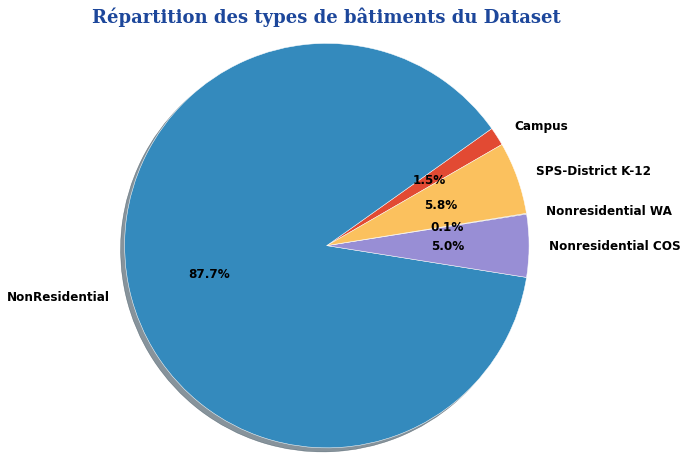

In [30]:
building_type = data.groupby(by='BuildingType')['OSEBuildingID'].nunique()

font_title = {'family': 'serif',
              'color':  '#1d479b',
              'weight': 'bold',
              'size': 18,
             }

fig, ax = plt.subplots(figsize=(8,8))
ax.pie(building_type.values, labels=building_type.index, 
       autopct='%1.1f%%', shadow=True, startangle=30,
       textprops=dict(color="black",size=12, weight="bold"))
ax.axis('equal')
ax.set_title("Répartition des types de bâtiments du Dataset", fontdict=font_title)
plt.show()

la majeur partie des bâtiments sont typés **"NonResidential"**. Nous pouvons visualiser les diverses catégories représentées dans ce type de bâtiments :

In [31]:
data.loc[(data['BuildingType']=="NonResidential"),'PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    290
Other                          189
Warehouse                      180
Large Office                   168
Mixed Use Property             103
Retail Store                    92
Hotel                           75
Worship Facility                70
Distribution Center             51
Medical Office                  41
Supermarket / Grocery Store     40
K-12 School                     39
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      11
Laboratory                      10
Hospital                        10
Non-Refrigerated Warehouse       2
Low-Rise Multifamily             1
Restaurant\n                     1
Name: PrimaryPropertyType, dtype: int64

Ici, on remarque que des catégories sont des **doublons avec un caractère d'échappement**. Nous allons corriger ce problème :

In [32]:
import re
regex = re.compile(r'[\n\r\t]')
data['PrimaryPropertyType'] = [regex.sub("", item) for index, item in data.PrimaryPropertyType.iteritems()]
data.loc[(data['BuildingType']=="NonResidential"),'PrimaryPropertyType'].value_counts()

Small- and Mid-Sized Office    290
Other                          189
Warehouse                      180
Large Office                   168
Mixed Use Property             103
Retail Store                    92
Hotel                           75
Worship Facility                70
Distribution Center             51
Medical Office                  41
Supermarket / Grocery Store     40
K-12 School                     39
Self-Storage Facility           28
Residence Hall                  21
Senior Care Community           20
University                      17
Refrigerated Warehouse          12
Restaurant                      12
Hospital                        10
Laboratory                      10
Non-Refrigerated Warehouse       2
Low-Rise Multifamily             1
Name: PrimaryPropertyType, dtype: int64

Les bureaux de petite et moyenne taille représentent la plus grande part des bâtiments non résidentiels.

### <font color="#2cb7b0" id="section_2_2">2.2. Les années de construction</font>
Nous allons regarder les distribution des années de construction des bâtiments de Seattle :

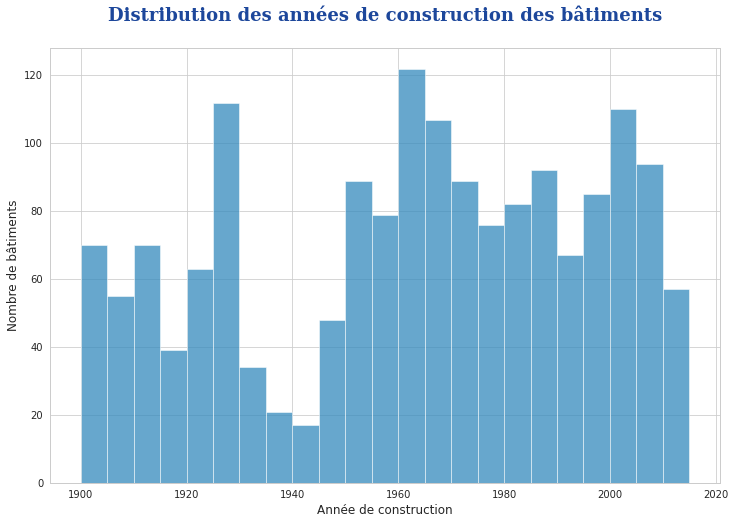

In [33]:
fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=data, x='YearBuilt', bins=int((data.YearBuilt.max() - data.YearBuilt.min())/5))
ax.set_xlabel("Année de construction")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution des années de construction des bâtiments\n", fontdict=font_title)
plt.show()

Plus que l'année de construction, il serait intéressant de traiter l'**age des bâtiments** pour réduire la dispersion des données et lier l'année des relevés. Nous allons donc créer cette nouvelle variable et supprimer l'année de construction :

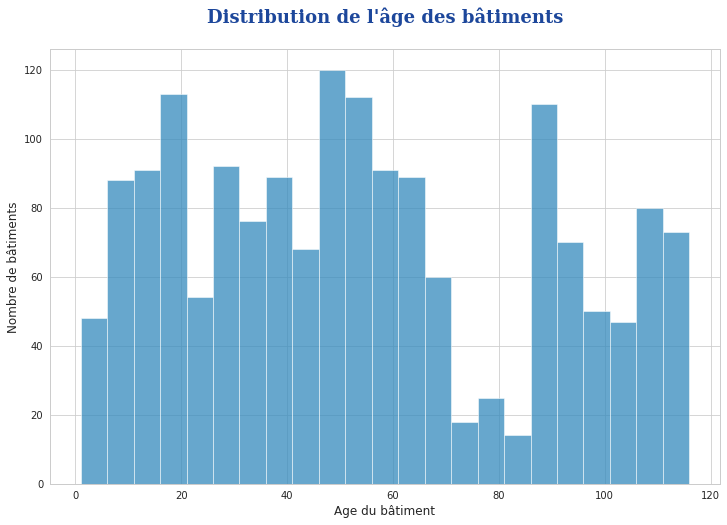

In [34]:
data['BuildingAge'] = data['DataYear'] - data['YearBuilt']
data.drop('YearBuilt', axis=1, inplace=True)

fig = plt.figure(figsize=(12,8))
ax = sns.histplot(data=data, x='BuildingAge', bins=int((data.BuildingAge.max() - data.BuildingAge.min())/5))
ax.set_xlabel("Age du bâtiment")
ax.set_ylabel("Nombre de bâtiments")
plt.title(f"Distribution de l'âge des bâtiments\n", fontdict=font_title)
plt.show()

### <font color="#2cb7b0" id="section_2_3">2.3. Les corrélations linéaires</font>

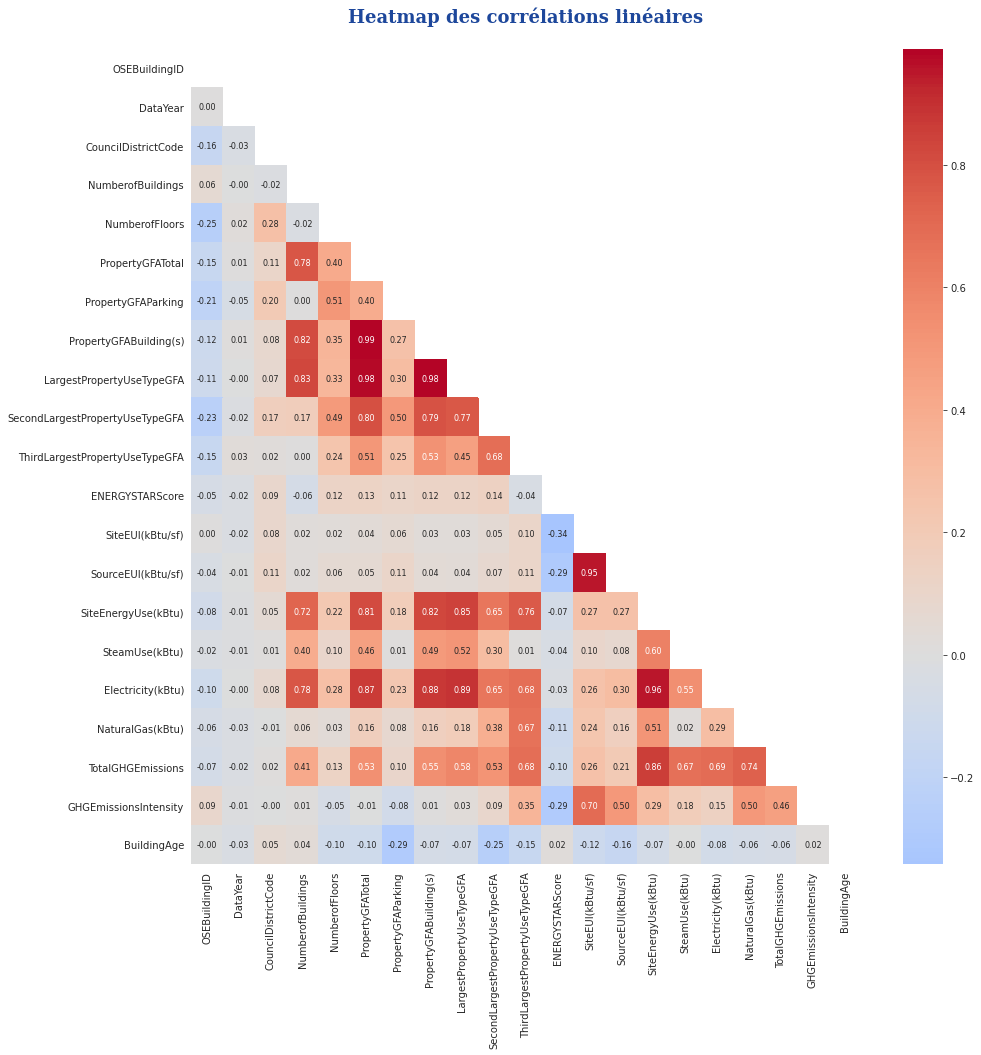

In [35]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", 
          fontdict=font_title)
plt.show()

Pour les varaibles à prédire `TotalGHGEmissions` et `SiteEnergyUse(kBtu)`, on remarque des corrélations linéaires quasi similaires avec les variables de relevés (les consommations) mais également avec le nombre de batiments ou d'étages ains que les surfaces au sol. 

On remarque sur ce Heatmap de fortes corrélations linéaires entre variables. Ces corrélations peuvent amener des problèmes de colinéarité dans nos futurs modèles. Isolons donc les **paires de variables avec des corrélations de Pearson supérieurs à 0.7** :

In [36]:
threshold = 0.7
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
44,PropertyGFABuilding(s),PropertyGFATotal,0.990146
42,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,0.983214
40,PropertyGFATotal,LargestPropertyUseTypeGFA,0.978200
38,Electricity(kBtu),SiteEnergyUse(kBtu),0.956707
36,SourceEUI(kBtu/sf),SiteEUI(kBtu/sf),0.951789
34,Electricity(kBtu),LargestPropertyUseTypeGFA,0.886509
32,PropertyGFABuilding(s),Electricity(kBtu),0.876935
30,Electricity(kBtu),PropertyGFATotal,0.867333
28,SiteEnergyUse(kBtu),TotalGHGEmissions,0.862087
26,SiteEnergyUse(kBtu),LargestPropertyUseTypeGFA,0.845066


On remarque que les variables suffixées GFA présentent de fortes corrélations avec plusieurs autres variables. Nous allons donc **créer de nouvelles variables** pour tenter de gommer ces corrélations linéaires :

In [37]:
def split_words(df, column = None):
  list_words = set()
  for word in df[column].str.split(','):
    if isinstance(word, float):
      continue
    list_words = set().union(word, list_words)
  return list(list_words)

list_use_type = split_words(data, 'ListOfAllPropertyUseTypes')
print("Nombre de type d'usages dans la base : {}".format(len(list_use_type)))

Nombre de type d'usages dans la base : 117


Réaliser un OneHotEncoder sur 117 types d'usage ne serait pas oportun. Nous allons donc créer une variable nous donnant le **nombre total d'usage du bâtiment**, puis supprimer la liste complète des usages :

In [38]:
data['TotalUseTypeNumber'] = [str(word).count(",") + 1 for word in data['ListOfAllPropertyUseTypes'].str.split(',')]
data.drop('ListOfAllPropertyUseTypes', axis=1, inplace=True)

Nous allons à présent convertir les différentes surfaces (Buildings et Parking) en **pourcentage de la surface totale** et nous conserverons uniquement ces 2 variables en supprimant les variables `LargestPropertyUseTypeGFA`, `SecondLargestPropertyUseTypeGFA`, `ThirdLargestPropertyUseTypeGFA` :

In [39]:
gfa_features = search_componant(data, suffix='GFA')
data[['TotalUseTypeNumber'] + gfa_features].head(10)

,TotalUseTypeNumber,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA
0,1,111077.0,0.0,111077.0,NaN,NaN,NaN
1,1,98370.0,25920.0,72450.0,98370.0,NaN,NaN
2,5,193788.0,37854.0,155934.0,138672.0,47539.0,11166.0
3,2,76598.0,21410.0,55188.0,55188.0,21410.0,NaN
4,2,186971.0,0.0,186971.0,186977.0,115477.0,NaN
5,1,66968.0,0.0,66968.0,NaN,NaN,NaN
6,2,434475.0,250000.0,184475.0,434475.0,250000.0,NaN
7,2,192960.0,32160.0,160800.0,135173.0,32000.0,NaN
8,1,54171.0,0.0,54171.0,NaN,NaN,NaN
9,3,83448.0,15479.0,67969.0,42527.0,27961.0,529.0


In [40]:
#On calcule les ratios
data['GFABuildingRate'] = (round((data['PropertyGFABuilding(s)'].fillna(0)
                                  /data['PropertyGFATotal'].fillna(0)),5))
data['GFAParkingRate'] = (round((data['PropertyGFAParking'].fillna(0)
                                 /data['PropertyGFATotal'].fillna(0)),5))

#On supprime les variables inutiles
data.drop(['LargestPropertyUseTypeGFA', 
           'SecondLargestPropertyUseTypeGFA',
           'SecondLargestPropertyUseType',
           'ThirdLargestPropertyUseTypeGFA',
           'ThirdLargestPropertyUseType',
           'PropertyGFAParking',
           'PropertyGFABuilding(s)'],
         axis=1, inplace=True)

#On complète les usages de la partie la plus large
data['LargestPropertyUseType'] = data['LargestPropertyUseType'].fillna("Unknown")
data['NumberofFloors'] = data['NumberofFloors'].fillna(1)

Nous pouvons également calculer la **surface moyenne par bâtiment et par étage** :

In [41]:
data['GFAPerBuilding'] = round((data['PropertyGFATotal'] / data['NumberofBuildings']),3)
data['GFAPerFloor'] = round((data['PropertyGFATotal'] / data['NumberofFloors']),3)

In [42]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 1697
Data columns (total 36 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1678 non-null   int64  
 1   DataYear                       1678 non-null   int64  
 2   BuildingType                   1678 non-null   object 
 3   PrimaryPropertyType            1678 non-null   object 
 4   PropertyName                   1678 non-null   object 
 5   Address                        1678 non-null   object 
 6   City                           1678 non-null   object 
 7   State                          1678 non-null   object 
 8   ZipCode                        1662 non-null   object 
 9   TaxParcelIdentificationNumber  1678 non-null   object 
 10  CouncilDistrictCode            1678 non-null   int64  
 11  Neighborhood                   1678 non-null   object 
 12  Latitude                       1678 non-null   o

Les données sont à présent bien complétées. Nous allons vérifier l'impact de ce feature engineering sur la matrice des corrélations linéaires :

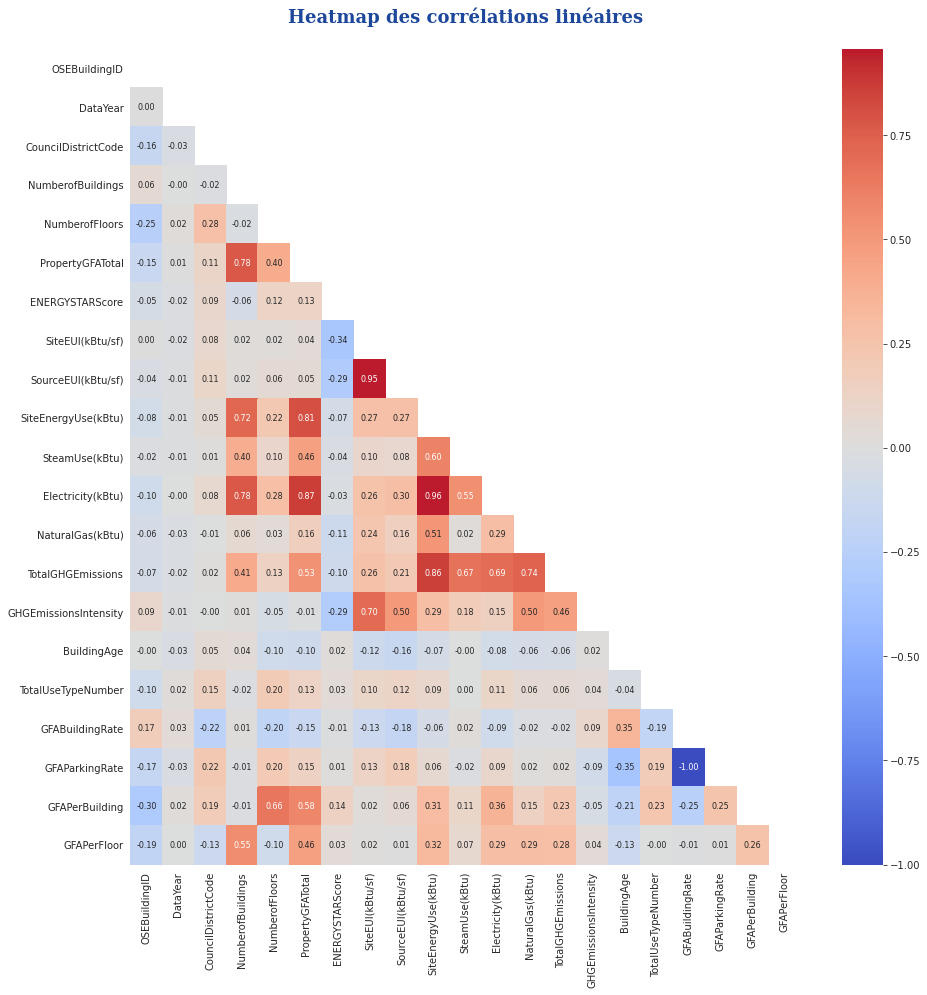

In [43]:
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15,15))
ax = sns.heatmap(corr, annot=True, fmt=".2f", annot_kws={'size':8}, 
                 mask=mask, center=0, cmap="coolwarm")
plt.title(f"Heatmap des corrélations linéaires\n", 
          fontdict=font_title)
plt.show()

In [44]:
threshold = 0.7
corr_pairs = corr.unstack().sort_values(kind="quicksort")
strong_corr = (pd.DataFrame(corr_pairs[(abs(corr_pairs) > threshold)])
               .reset_index().rename(columns={0:'corr_coeff'}))
strong_corr = strong_corr[(strong_corr.index%2 == 0) & (strong_corr['level_0'] != strong_corr['level_1'])]
strong_corr.sort_values('corr_coeff', ascending=False)

,level_0,level_1,corr_coeff
20,Electricity(kBtu),SiteEnergyUse(kBtu),0.956707
18,SourceEUI(kBtu/sf),SiteEUI(kBtu/sf),0.951789
16,Electricity(kBtu),PropertyGFATotal,0.867333
14,TotalGHGEmissions,SiteEnergyUse(kBtu),0.862087
12,PropertyGFATotal,SiteEnergyUse(kBtu),0.810407
10,NumberofBuildings,Electricity(kBtu),0.775949
8,NumberofBuildings,PropertyGFATotal,0.775589
6,NaturalGas(kBtu),TotalGHGEmissions,0.736970
4,NumberofBuildings,SiteEnergyUse(kBtu),0.724128
2,GHGEmissionsIntensity,SiteEUI(kBtu/sf),0.703791


Vérification de **multicolinéarité avec le VIF** *(Variance Inflation Factor)* : $VIF = \frac{1}{1-R^2}$

In [45]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

strong_corr_features = list(set(list(strong_corr['level_0'].values) + list(strong_corr['level_1'].values)))
X = data[strong_corr_features].replace([np.inf, -np.inf], np.nan)
X = X.dropna()

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                   for i in range(len(X.columns))]
vif_data[vif_data['VIF'] > 5]

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,feature,VIF
0,NaturalGas(kBtu),8.927115
1,Electricity(kBtu),332.919384
2,PropertyGFATotal,5.876687
3,TotalGHGEmissions,75.899891
5,GHGEmissionsIntensity,8.421085
6,SourceEUI(kBtu/sf),37.647406
7,SiteEnergyUse(kBtu),733.951440
9,SiteEUI(kBtu/sf),53.300640
10,NumberofBuildings,8.603262


Des scores VIF supérieur à 5 indiquent généralement une forte multicolinéarité. Ces variables fortement corrélées risquent d'impacter nos modèles.       
Les features suffixées `EUI(kBtu/sf)`, sont des variables dont les valeurs sont ramenées à la surface par étage. Nous allons les supprimer car nous avons créer des variables pouvant permettre de ramener nos données à l'étage ou au building. Idem pour la variable `GHGEmissionsIntensity` 

In [46]:
Eui_features = search_componant(data, suffix='EUI(kBtu/sf)') + ['GHGEmissionsIntensity']
data.drop(Eui_features, axis=1, inplace=True)

### <font color="#2cb7b0" id="section_2_4">2.4. Analyse des variables à prédire</font>

Pour rappel, les 2 variables à prédire dans le cadre de notre mission sont :
- `TotalGHGEmissions`
- `SiteEnergyUse(kBtu)`

Nous allons donc réaliser quelques analyses exploratoires sur ces features :

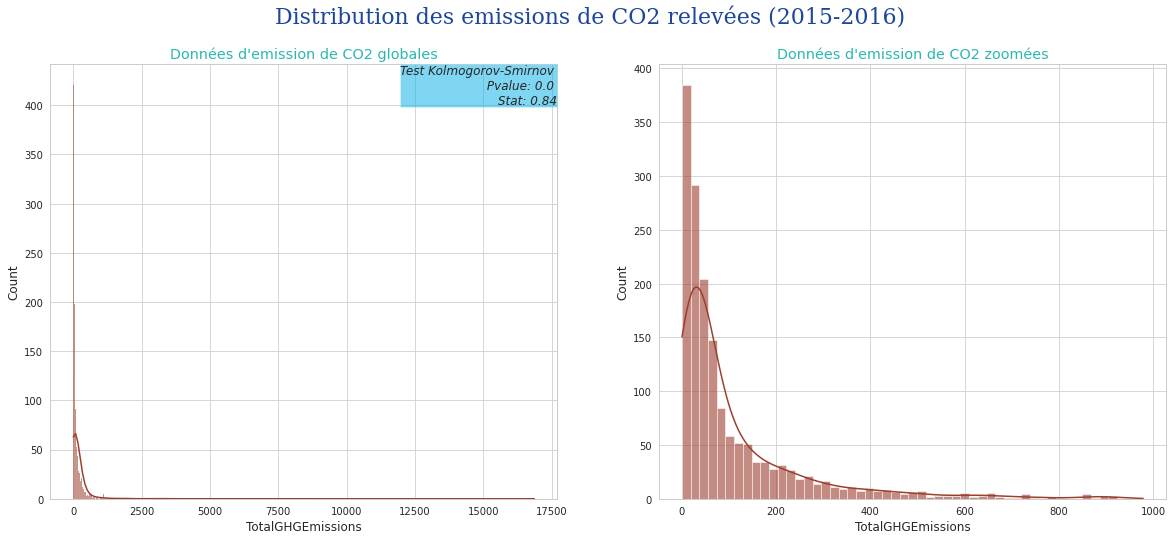

In [47]:
import scipy.stats as stats

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
left, width = 0, 1
bottom, height = 0, 1
right = left + width
top = bottom + height

sns.histplot(data=data, x="TotalGHGEmissions", kde=True, ax=axes[0], color="#9C3E2D", alpha=0.6)
axes[0].set_title("Données d'emission de CO2 globales", color='#2cb7b0')

#Test de Kolmogorov-Smirnov
kstest = stats.kstest(data['TotalGHGEmissions'].notnull(),'norm')
axes[0].text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=axes[0].transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})

sns.histplot(data=data[(data['TotalGHGEmissions']< 1000)], x="TotalGHGEmissions", kde=True, ax=axes[1], color="#9C3E2D", alpha=0.6)
axes[1].set_title("Données d'emission de CO2 zoomées", color='#2cb7b0')

plt.suptitle("Distribution des emissions de CO2 relevées (2015-2016)", 
             fontdict=font_title, fontsize=22)
plt.show()

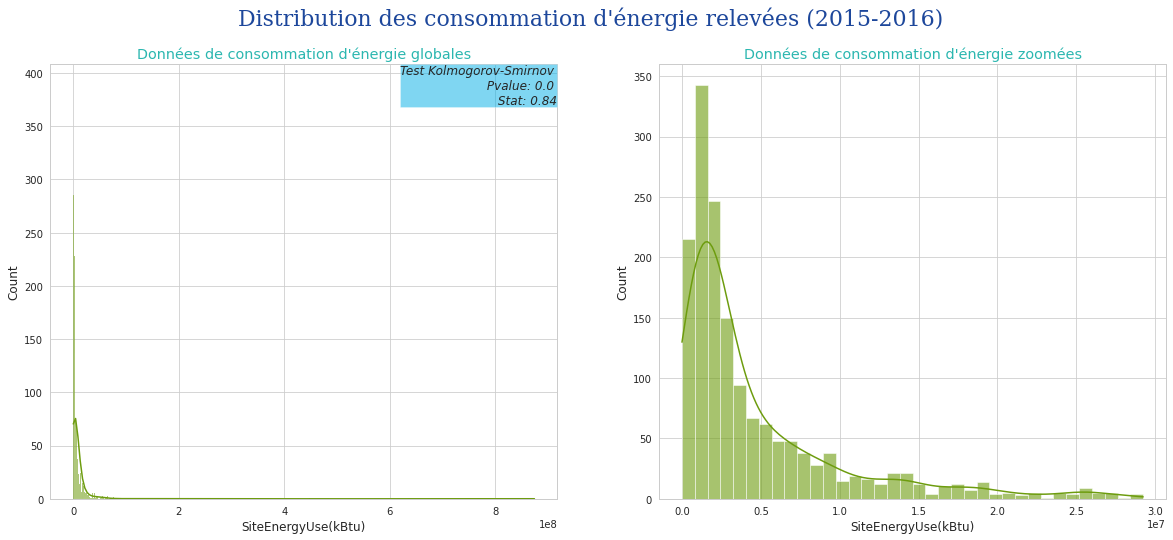

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

sns.histplot(data=data, x="SiteEnergyUse(kBtu)", kde=True, ax=axes[0], color="#6D9C0E", alpha=0.6)
axes[0].set_title("Données de consommation d'énergie globales", color='#2cb7b0')

#Test de Kolmogorov-Smirnov
kstest = stats.kstest(data['SiteEnergyUse(kBtu)'].notnull(),'norm')
axes[0].text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
            horizontalalignment='right',
            verticalalignment='top',
            style='italic', transform=axes[0].transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})

sns.histplot(data=data[(data['SiteEnergyUse(kBtu)']< 0.3*10**8)], x="SiteEnergyUse(kBtu)", kde=True, ax=axes[1], color="#6D9C0E", alpha=0.6)
axes[1].set_title("Données de consommation d'énergie zoomées", color='#2cb7b0')

plt.suptitle("Distribution des consommation d'énergie relevées (2015-2016)", 
             fontdict=font_title, fontsize=22)
plt.show()

En se basant sur les projections obtenus et les résultats des tests de Kolmogorov-Smirnov *(Pvalue < au niveau de test de 5%)* on rejette donc l'hypothèse de normalité des distributions de ces variables. 

Projettons à présent les scatterplots des distribition de ces 2 variables entre elles :

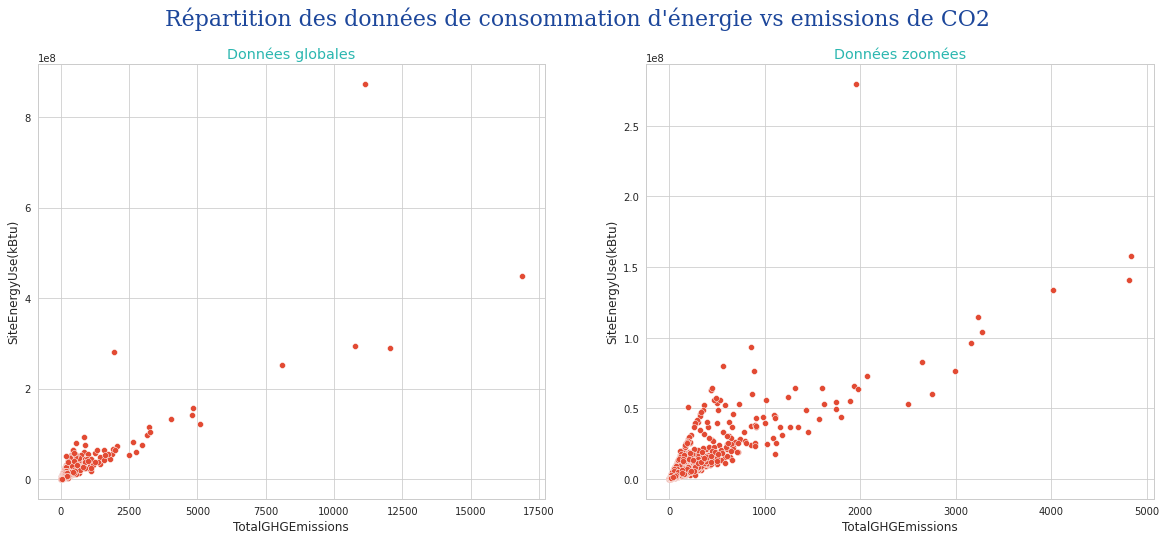

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.scatterplot(data=data, x="TotalGHGEmissions", y="SiteEnergyUse(kBtu)", ax=axes[0])
axes[0].set_title("Données globales", color='#2cb7b0')
sns.scatterplot(data=data[(data['TotalGHGEmissions'] < 5000)], x="TotalGHGEmissions", y="SiteEnergyUse(kBtu)", ax=axes[1])
axes[1].set_title("Données zoomées", color='#2cb7b0')
plt.suptitle("Répartition des données de consommation d'énergie vs emissions de CO2", fontdict=font_title, fontsize=22)
plt.show()

on remarque ici que la répartion des données d'emission de CO2 en fonction de la consommation d'énergie ne suivent pas uniquement 1 seule droite de régression linéaire si l'on zoom sur les données les plus représentées.

Regardons à présent si les coordonnées géographiques ont un impact sur les rejets et consommations. Pour cela, afin d'éviter les corrélations fortes entre Latitude et Longitude, nous allons calculer la **distance Harversine entre chaque point de coordonnées et le centre de Seattle** :

In [50]:
from math import radians, cos, sin, asin, sqrt

seattle_lat = 47.6062
seattle_lon = -122.3321

def haversine_distance(lat1, lng1, lat2, lng2, degrees=True):
    r = 3956 # rayon de la Terre en miles
    
    if degrees:
        lat1, lng1, lat2, lng2 = map(radians, [lat1, lng1, lat2, lng2])
    
    # Formule Haversine
    dlng = lng2 - lng1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlng/2)**2
    d = 2 * r * asin(sqrt(a))  

    return d

In [51]:
data['harvesine_distance'] = [haversine_distance(seattle_lat, seattle_lon, x, y) 
                              for x, y in zip(data.Latitude.astype(float), data.Longitude.astype(float))]

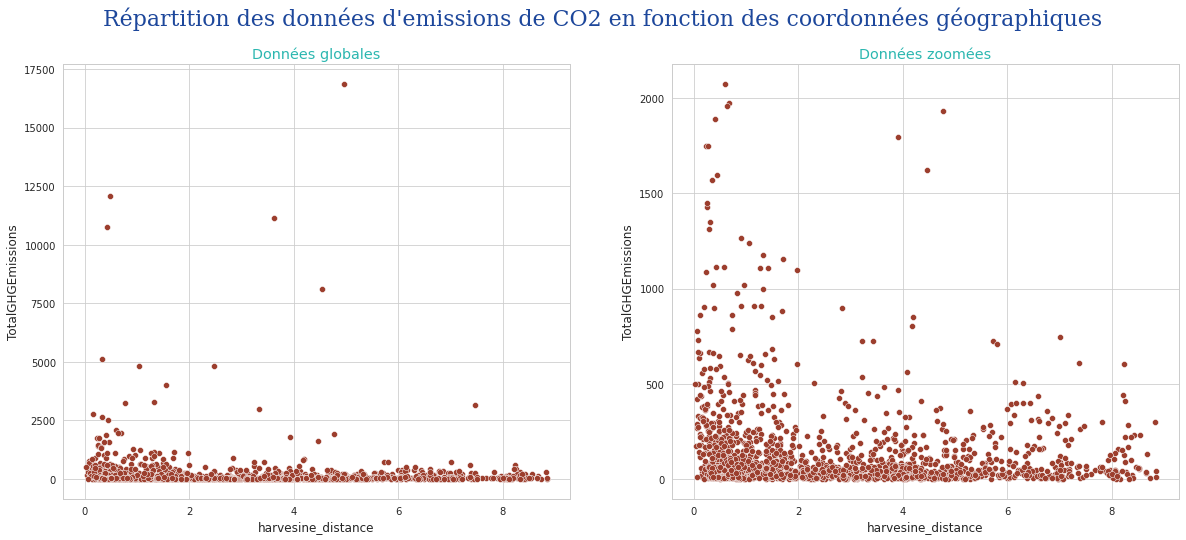

In [52]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.scatterplot(data=data, y="TotalGHGEmissions", x="harvesine_distance", color="#9C3E2D", ax=axes[0])
axes[0].set_title("Données globales", color='#2cb7b0')
sns.scatterplot(data=data[(data['TotalGHGEmissions'] < 2500)], y="TotalGHGEmissions", 
                x="harvesine_distance", color="#9C3E2D", ax=axes[1])
axes[1].set_title("Données zoomées", color='#2cb7b0')
plt.suptitle("Répartition des données d'emissions de CO2 en fonction des coordonnées géographiques", 
             fontdict=font_title, fontsize=22)
plt.show()

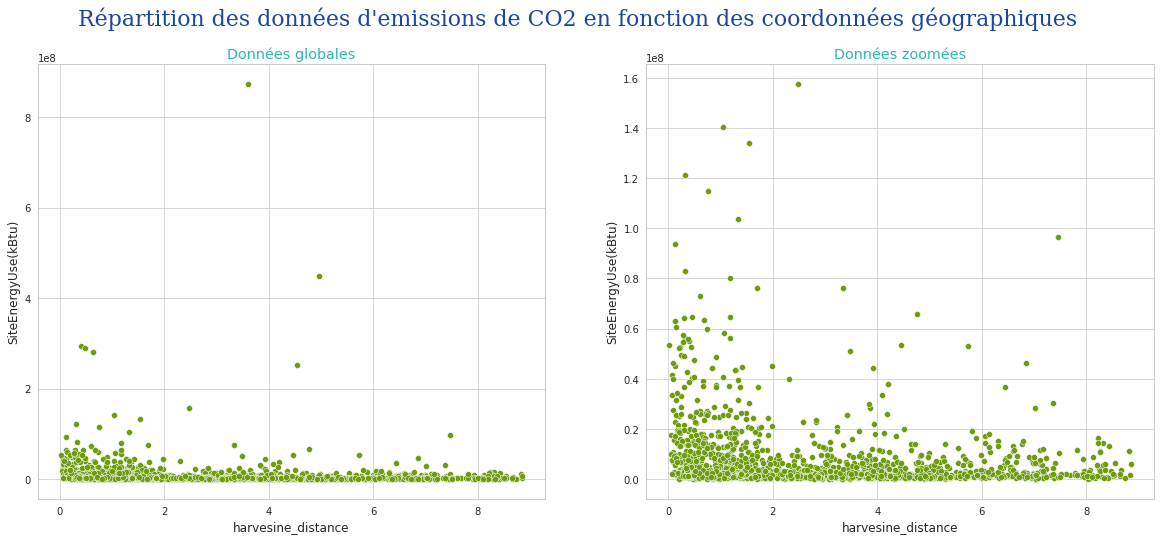

In [53]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.scatterplot(data=data, y="SiteEnergyUse(kBtu)", x="harvesine_distance", color="#6D9C0E", ax=axes[0])
axes[0].set_title("Données globales", color='#2cb7b0')
sns.scatterplot(data=data[(data['SiteEnergyUse(kBtu)'] < 2*10**8)], y="SiteEnergyUse(kBtu)", 
                x="harvesine_distance", color="#6D9C0E", ax=axes[1])
axes[1].set_title("Données zoomées", color='#2cb7b0')
plt.suptitle("Répartition des données d'emissions de CO2 en fonction des coordonnées géographiques", 
             fontdict=font_title, fontsize=22)
plt.show()

En regardant ces projections, il semble que **les coordonnées géographiques *(donc les adresses des bâtiments)* puissent avoir un impact sur les consommations d'égergie et rejets de CO2**.

D'autre part, la latitude et la longitude étant 2 variables fortement corrélées dans notre jeu de données, **nous allons supprimer ces 2 colonnes pour conserver uniquement ce point de coordonnée unique Harvesine** *(en fin de Notebook)*.

Nous allons à présent regarder la répartition de ces 2 variables en fonction du type de bâtiement.

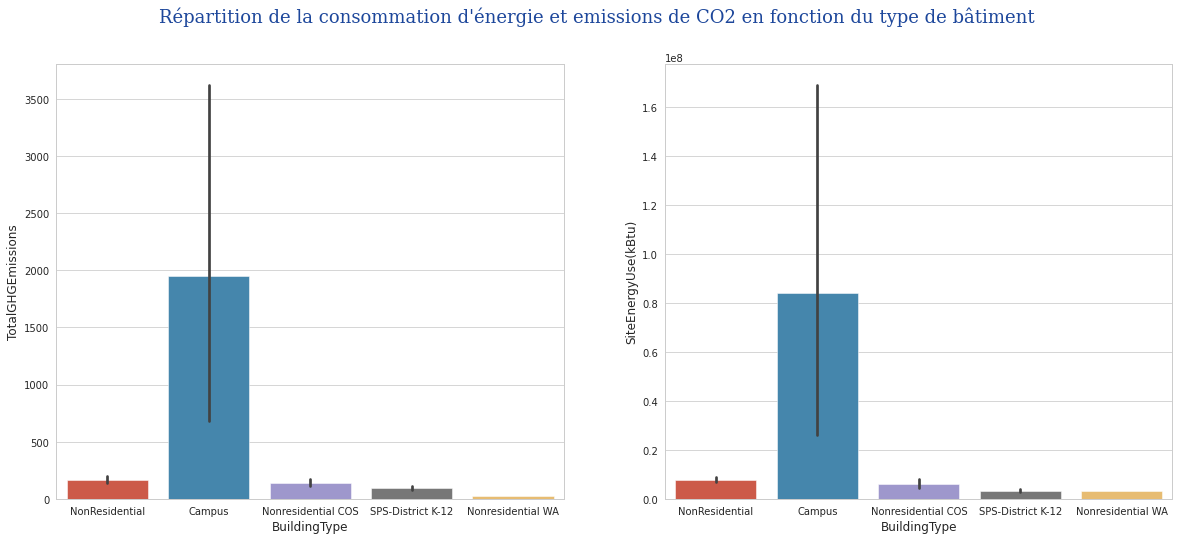

In [54]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))
sns.barplot(x='BuildingType',y='TotalGHGEmissions',data=data, ax=axes[0])
sns.barplot(x='BuildingType',y='SiteEnergyUse(kBtu)',data=data, ax=axes[1])
plt.suptitle("Répartition de la consommation d'énergie et emissions de CO2 en fonction du type de bâtiment", 
             fontdict=font_title, fontsize=18)
plt.show()

Sur ces diagrammes en barre, les campus se démarquent largement en terme de consommation et de rejets de CO2. Regardons à présent si l'âge des bâtiments a un impact sur les émissions de CO2 :

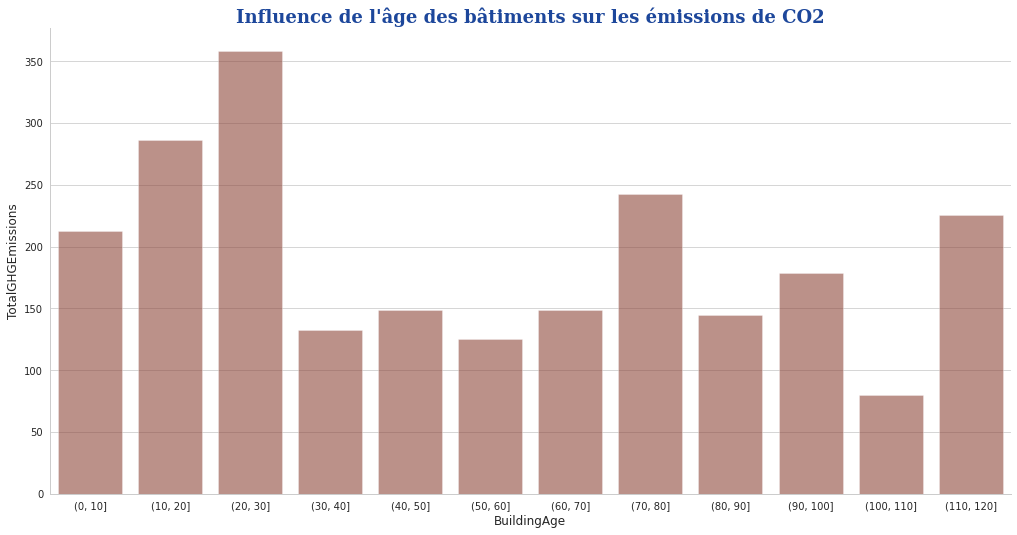

In [55]:
bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 20), (20, 30), (30, 40), (40, 50), 
                                     (50, 60), (60, 70), (70,80), (80,90), (90,100), 
                                     (100,110), (110,120)])

sns.catplot(
    data=data, kind="bar",
    x=pd.cut(data['BuildingAge'], bins=bins), y="TotalGHGEmissions",
    ci=None, color="#9C3E2D", alpha=.6,
    height=7, aspect=2
)
plt.title("Influence de l'âge des bâtiments sur les émissions de CO2", fontdict=font_title)
plt.show()

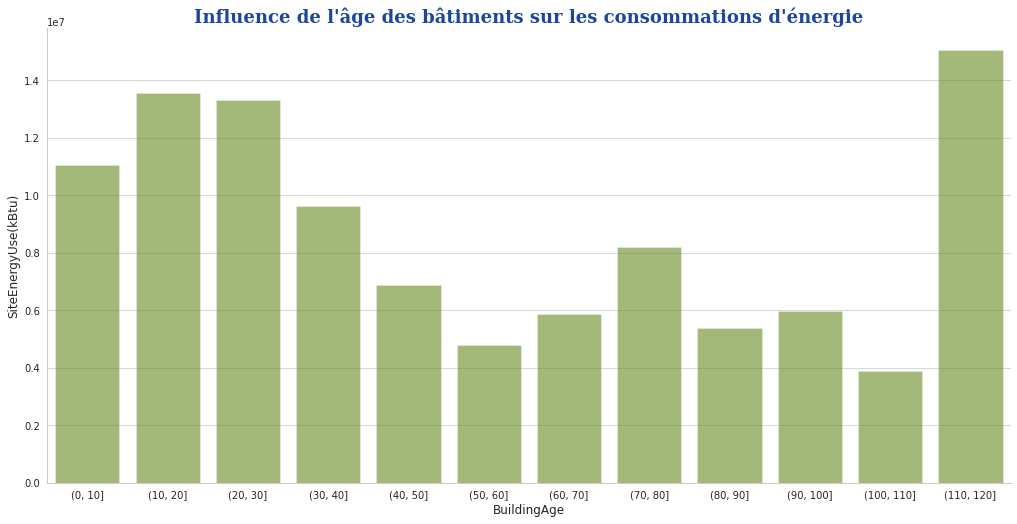

In [56]:
sns.catplot(
    data=data, kind="bar",
    x=pd.cut(data['BuildingAge'], bins=bins), y="SiteEnergyUse(kBtu)",
    ci=None, color="#6D9C0E", alpha=.6,
    height=7, aspect=2
)
plt.title("Influence de l'âge des bâtiments sur les consommations d'énergie", fontdict=font_title)
plt.show()

Les bâtiments de moins de 30 ans semblent avoir des consommations d'énergie et rejets de CO2 plus important que les buildings anciens, alors même que la variable `BuildingAge` n'est pas fortement corrélée à d'autres features *(comme la taille des bâtiments par exemple)*.

## <font color="#337da4" id="section_3">3. Dernières étapes de nettoyage</font>

Nous allons éliminer certaines variables qui ne seront pas utiles pour nos modélisations et vérifier les données incomplètes identifiées dans le jeu de données initial.

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1678 entries, 0 to 1697
Data columns (total 34 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   OSEBuildingID                  1678 non-null   int64  
 1   DataYear                       1678 non-null   int64  
 2   BuildingType                   1678 non-null   object 
 3   PrimaryPropertyType            1678 non-null   object 
 4   PropertyName                   1678 non-null   object 
 5   Address                        1678 non-null   object 
 6   City                           1678 non-null   object 
 7   State                          1678 non-null   object 
 8   ZipCode                        1662 non-null   object 
 9   TaxParcelIdentificationNumber  1678 non-null   object 
 10  CouncilDistrictCode            1678 non-null   int64  
 11  Neighborhood                   1678 non-null   object 
 12  Latitude                       1678 non-null   o

Vérifions la variable `ComplianceStatus` qui représente la conformité des données relevées :

In [58]:
data['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

In [59]:
print("Nombre de ligne identifiées comme non conforme : {}.".format(data[data['ComplianceStatus'] != "Compliant"].shape[0]))

Nombre de ligne identifiées comme non conforme : 103.


In [60]:
data = data[data['ComplianceStatus'] == "Compliant"]

Nous allons ensuite supprimer les variables `DefaultData`, `ComplianceStatus`, `TaxParcelIdentificationNumber`, `CouncilDistrictCode`, `City` 

In [61]:
data = data.drop(['DefaultData','ComplianceStatus', 'City',
                  'TaxParcelIdentificationNumber','CouncilDistrictCode'], axis=1)

## <font color="#337da4" id="section_4">4. Projection des établissements sur la carte de Seattle</font>

In [62]:
import folium
import folium.plugins

seattle_map = folium.Map(location=[seattle_lat, seattle_lon], zoom_start=11)

#Clusters
marker_cluster = folium.plugins.MarkerCluster().add_to(seattle_map)
for lat, lng, in zip(data.Latitude, data.Longitude):
    folium.Marker(location=[float(lat), float(lng)]).add_to(marker_cluster)

seattle_map

Et pour finir, nous supprimons les variables `Latitude` et `Longitude` puis **nous exportons le fichier cleané pour les modélisations qui seront effectuées dans un second Notebook** (https://www.kaggle.com/michaelfumery/sea-building-energy-and-ghg-prediction)

In [63]:
data = data.drop(['Latitude','Longitude'], axis=1)
data.set_index("OSEBuildingID").to_csv("/content/drive/MyDrive/Colab Notebooks/P3_prediction_energie_seattle/datas/building-energy-cleaned.csv")